# Classification de la Qualité des Diamants 

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

## Chargement et Nettoyage

In [165]:
df = pd.read_csv("data/diamonds.csv")
df = df.drop(df.columns[0], axis=1)

cut_map = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
color_map = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
clarity_map = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}

df['cut'] = df['cut'].map(cut_map)
df['color'] = df['color'].map(color_map)
df['clarity'] = df['clarity'].map(clarity_map)

## Feature Engineering 

In [166]:
df['volume'] = df['x'] * df['y'] * df['z']
df['volume'] = df['volume'].replace(0, 0.01) 

df['table_depth_ratio'] = df['table'] / df['depth']

df['lw_ratio'] = df['x'] / (df['y'] + 0.001)

## Info

In [167]:
df.shape

(53940, 13)

In [168]:
df.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,table_depth_ratio,lw_ratio
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,2.904097,3.405803,3.051020,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734,129.849407,0.931254,0.999098
std,0.474011,1.116600,1.701105,1.647136,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699,78.245255,0.048120,0.016857
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000,0.010000,0.683625,0.000000
25%,0.400000,2.000000,2.000000,2.000000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000,65.136830,0.898876,0.992441
50%,0.700000,3.000000,3.000000,3.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,114.808572,0.923825,0.995552
75%,1.040000,4.000000,5.000000,4.000000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000,170.842451,0.956240,1.006743
max,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,3840.598060,1.621160,1.615179


In [169]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,table_depth_ratio,lw_ratio
0,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43,38.202030,0.894309,0.992213
1,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31,34.505856,1.020067,1.012757
2,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31,38.076885,1.142355,0.994842
3,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63,46.724580,0.929487,0.992673
4,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75,51.917250,0.916272,0.997472


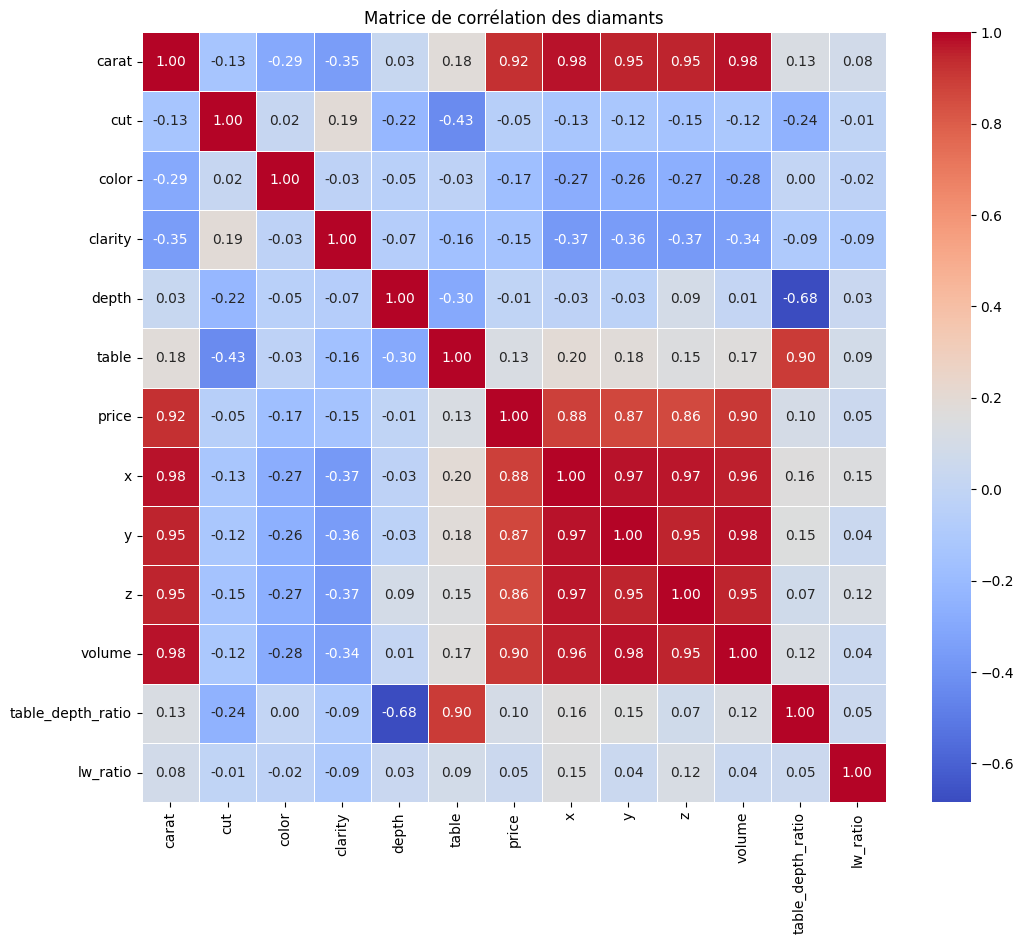

In [170]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation des diamants")
plt.show()

C:\Users\lepot\AppData\Local\Temp\ipykernel_11412\448231917.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_plot, x='cut_label', order=order, palette='viridis')


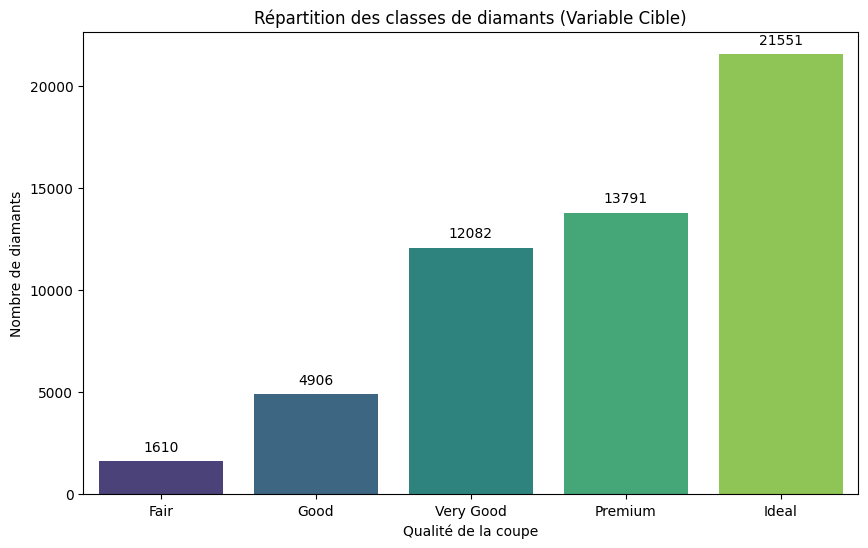

In [171]:
df_plot = df.copy()
inv_cut_map = {0: 'Fair', 1: 'Good', 2: 'Very Good', 3: 'Premium', 4: 'Ideal'}
df_plot['cut_label'] = df_plot['cut'].map(inv_cut_map)

plt.figure(figsize=(10, 6))
order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'] 
ax = sns.countplot(data=df_plot, x='cut_label', order=order, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Répartition des classes de diamants (Variable Cible)')
plt.xlabel('Qualité de la coupe')
plt.ylabel('Nombre de diamants')
plt.show()

## Préparation des données 

In [172]:
target = 'cut'
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)


## Modèle Decision Tree

In [173]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)

y_pred_train = tree_classifier.predict(X_train)
y_pred_test = tree_classifier.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy train : {accuracy_train:.2f}")
print(f"Accuracy test: {accuracy_test:.2f}")

Accuracy train : 1.00
Accuracy test: 0.73


### Decision Tree avec GRIDSEARCHCV

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 10, 50],
    'min_samples_leaf': [1, 5, 10]
}

dt_base = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt_base, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=1, 
    scoring='accuracy'
)

print("Recherche des meilleurs hyperparamètres en cours...")
grid_search.fit(X_train, y_train)

print("-" * 30)
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score de validation (cv) : {grid_search.best_score_:.4f}")

best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

print("-" * 30)
print(f"Accuracy Test (Optimisé) : {accuracy_best:.4f}")

Recherche des meilleurs hyperparamètres en cours...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
------------------------------
Meilleurs paramètres : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 50}
Meilleur score de validation (cv) : 0.8048
------------------------------
Accuracy Test (Optimisé) : 0.8039


## Modèle TensorFlow

In [175]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(5, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

model.summary()

c:\Users\lepot\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,597 (182.02 KB)

 Trainable params: 45,701 (178.52 KB)

 Non-trainable params: 896 (3.50 KB)

## Entraînement

In [176]:
classes_uniques = np.unique(y_train)
poids = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_uniques,
    y=y_train
)
poids_dict = dict(zip(classes_uniques, poids))

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, 
    y_train_cat, 
    epochs=50, 
    batch_size=64, 
    validation_data=(X_test_scaled, y_test_cat),
    callbacks=[early_stopping, lr_scheduler],
    class_weight=poids_dict,
    verbose=1
)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5761 - loss: 1.0802 - precision: 0.6451 - recall: 0.4700 - val_accuracy: 0.7234 - val_loss: 0.6952 - val_precision: 0.7836 - val_recall: 0.6297 - learning_rate: 0.0010
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6628 - loss: 0.8293 - precision: 0.7226 - recall: 0.5719 - val_accuracy: 0.7247 - val_loss: 0.6868 - val_precision: 0.7808 - val_recall: 0.6408 - learning_rate: 0.0010
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6837 - loss: 0.7769 - precision: 0.7336 - recall: 0.6012 - val_accuracy: 0.7318 - val_loss: 0.6818 - val_precision: 0.7824 - val_recall: 0.6505 - learning_rate: 0.0010
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6963 - loss: 0.7492 - precision: 0.7392 - recall: 0.6218 - val_accuracy: 0.7560 - val_loss: 0.6462 - val_precision: 0.7960 - val_recall: 0.6846 - learning_rate: 0.0010
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 

## Évaluation et Résultats

Test Accuracy : 0.7805
Test Precision: 0.8041
Test Recall   : 0.7467
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


<Figure size 1000x800 with 0 Axes>

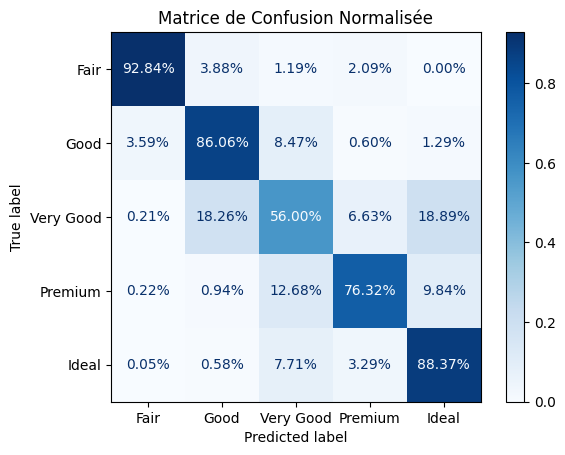

In [177]:
loss, acc, prec, rec = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Test Accuracy : {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall   : {rec:.4f}")

y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
disp.plot(cmap='Blues', values_format='.2%')
plt.title("Matrice de Confusion Normalisée")
plt.show()